# Table of Contents

- [Analysis of Nematic Ordering](#analysis-of-nematic-ordering)
  - [Packages](#packages)
  - [Parameter Search](#parameter-search)
    - [Set Parameter Search](#set-parameter-search)
      - [For SDCM](#for-sdcm)
      - [For NPY File](#for-npy-file)
  - [Analyze Order Parameter Decay](#analyze-order-parameter-decay)
  - [Calculate Vectors for Image](#calculate-vectors-for-image)

# Analysis of Nematic Ordering
Author: Felix Romer

Last updated: 09.12.2024

Environment: `aft312`

## Packages

This section imports the required libraries for image processing, data analysis, and visualization.

In [2]:
import skimage.io as io                 # For reading in images
import glob as glob                     # For creating lists of filenames
import AFT_tools as AFT                 # AFT (Alignment by Fourier Transform) functions
import numpy as np                      # For math
import matplotlib.pyplot as plt         # For plotting
import os                               # For saving to disk
import pandas as pd                     # Data analysis

## Parameter Search

This section sets up the parameters for analyzing nematic ordering in images.



### Set Parameter Search

Define the main parameters for the analysis, including window size, overlap, and calibration factors.

In [7]:
parent_dir        = '/media/felix/Felixdrive/Test/' # Images has to be gray scale (8 bit)
min_win_size      = 75
max_winsize       = 175 # If you dont want, set to 0
win_size_interval = 25
overlap           = 0.5
fcal              = 0.2767889
av_cell_size      = 1.1 * 10**3

#### For SDCM

Adjust the parameters for SDCM (Spatially Dependent Calibration Method).

In [8]:
factor_px_to_um_SDCM = 0.3478664

min_winzize_old   = min_win_size
min_win_size      = int(min_win_size/fcal*factor_px_to_um_SDCM)
max_winsize_old   = max_winsize
max_winsize       = int(max_winsize/fcal*factor_px_to_um_SDCM) 
interval_old      = win_size_interval
win_size_interval = int(win_size_interval/fcal*factor_px_to_um_SDCM)
overlap           = 0.5
fcal_old          = fcal
fcal              = factor_px_to_um_SDCM
av_cell_size      = 1.1 * 10**3
winsizemap = {key + 1 if key % 2 == 0 else key: value for key, value in zip(range(min_win_size, max_winsize+1, win_size_interval), range(min_winzize_old, max_winsize_old+1, interval_old))}
[win_size_interval, min_win_size, max_winsize, fcal]

[31, 94, 219, 0.3478664]

#### For NPY File

Load `.npy` files and define flow direction mappings for further analysis.

In [9]:
folders = [
           '/media/felix/Felixdrive/Analysis2025/20250204_Chip14_Macrophage_adhesion/Segmentation/'
           ]
all_files = [os.path.join(image_dir, file) for image_dir in folders for file in os.listdir(image_dir)]
all_files = [file for file in all_files if file.endswith('.npy')]
flow_direction_map = {
    "to_top": 0,
    "to_right": 1,
    "to_bottom": 2,
    "to_left": 3
}


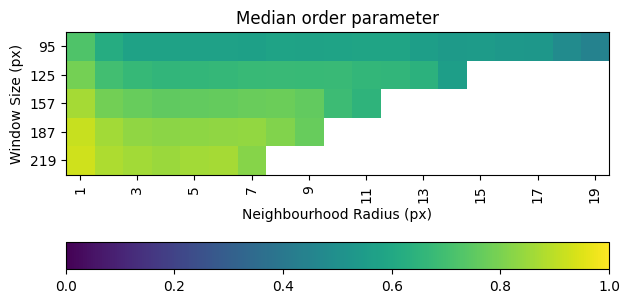

In [10]:
Order_dataframe, window_neighborhood = AFT.parameter_search(all_files, min_win_size, win_size_interval, overlap, flow_direction_map,
                                                            flow_direction='to_right', display_orientation='to_top', max_win_size= max_winsize,
                                                            plot_figure=True, from_cellpose_segmentation=True, crop_image=False, pad=True)


In [ ]:
Order_dataframe_edit = Order_dataframe.copy()
Order_dataframe_edit.columns = ['Window size', 'Neighborhood radius', 'Order parameter', 'Image']
Order_dataframe_edit['Date']                    = Order_dataframe_edit['Image'].str.split('/').str[-1].str.split('_').str[2]
Order_dataframe_edit['Infection Status']        = Order_dataframe_edit['Image'].str.split('/').str[-1].str.split('_').str[5]
Order_dataframe_edit['Chip']                    = Order_dataframe_edit['Image'].str.split('/').str[-1].str.split('_').str[3].str.replace('Chip', '').astype(int)
Order_dataframe_edit['Channel']                 = Order_dataframe_edit['Image'].str.split('/').str[-1].str.split('_').str[4].str.replace('Channel', '').astype(int)
Order_dataframe_edit['Replicate']               = Order_dataframe_edit['Image'].str.split('/').str[-1].str.split('_').str[-2].astype(int)
Order_dataframe_edit['True_Winsize']            = Order_dataframe_edit['Window size']
Order_dataframe_edit['Window size']             = Order_dataframe_edit['Window size'].apply(lambda x: winsizemap[x])
Order_dataframe_edit['Neighbourhood']           = Order_dataframe_edit['Neighborhood radius'].apply(lambda x: f'{x}x')
Order_dataframe_edit['File name']               = Order_dataframe_edit['Image'].str.split('/').str[-1]
Order_dataframe_edit['Radial Distance (µm)']    = ((Order_dataframe_edit['Window size'] * fcal_old / 2)).astype(int) * Order_dataframe_edit['Neighborhood radius']
Order_dataframe_edit['Window size (um2)']       = ((Order_dataframe_edit['Radial Distance (µm)'] *2 )** 2 ).astype(int)
Order_dataframe_edit['Cells_per_neighbourhood'] = None

save_name = '/media/felix/Felixdrive/Analysis2025/20250204_Chip14_Macrophage_adhesion/Nematic_ordering/20250116_Order_parameters_nocrop.csv'
Order_dataframe_edit.to_csv(save_name, index=False)

## Analyze Order Parameter Decay

This section analyzes the decay of the order parameter over radial distances.

Environment: `analysis_env`

### Environment Setup

Enable autoreload for modules and import libraries for data manipulation, visualization, and statistical analysis.

In [1]:
# Enable autoreload for modules
%load_ext autoreload
%autoreload 2

# Data manipulation and analysis
import numpy as np
import pandas as pd 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# File and OS operations
import os
import scipy.io as sio

# Statistical analysis
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp

# Analysis Utilities
import Analysis_tools as AT


In [2]:
save_name = '/media/felix/Felixdrive/Analysis2025/Chip_all/2025_03_18_Chip014_016_019/20250116_Order_parameters_nocrop.csv'
df_flow = pd.read_csv(save_name)
df_flow

,Window size,Neighborhood radius,Order parameter,Image,Date,Channel,Chip,Replicate,True_Winsize,Neighbourhood,File name,repicate,Radial Distance (µm),Window size (um2),Cells_per_neighbourhood,Infection Status
0,75,1,0.606156,/media/felix/Felixdrive/Analysis2025/20250307_...,20250307,2,19,1,95,1x,20250307_Chip16_Ch2_MF_adhesion_DapiVEcad_001_...,20250307.0,10,430,NaN,Uninfected
1,75,2,0.413374,/media/felix/Felixdrive/Analysis2025/20250307_...,20250307,2,19,1,95,2x,20250307_Chip16_Ch2_MF_adhesion_DapiVEcad_001_...,20250307.0,20,430,NaN,Uninfected
2,75,3,0.307306,/media/felix/Felixdrive/Analysis2025/20250307_...,20250307,2,19,1,95,3x,20250307_Chip16_Ch2_MF_adhesion_DapiVEcad_001_...,20250307.0,30,430,NaN,Uninfected
3,75,4,0.242674,/media/felix/Felixdrive/Analysis2025/20250307_...,20250307,2,19,1,95,4x,20250307_Chip16_Ch2_MF_adhesion_DapiVEcad_001_...,20250307.0,40,430,NaN,Uninfected
4,75,5,0.194154,/media/felix/Felixdrive/Analysis2025/20250307_...,20250307,2,19,1,95,5x,20250307_Chip16_Ch2_MF_adhesion_DapiVEcad_001_...,20250307.0,50,430,NaN,Uninfected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245,175,3,0.920651,/media/felix/Felixdrive/Analysis2025/20250204_...,20250204,12,14,3,219,3x,Nuclei_VeCad_20250204_Chip14_Channel012_Contro...,NaN,72,20736,NaN,Control
3246,175,4,0.909867,/media/felix/Felixdrive/Analysis2025/20250204_...,20250204,12,14,3,219,4x,Nuclei_VeCad_20250204_Chip14_Channel012_Contro...,NaN,96,36864,NaN,Control
3247,175,5,0.902281,/media/felix/Felixdrive/Analysis2025/20250204_...,20250204,12,14,3,219,5x,Nuclei_VeCad_20250204_Chip14_Channel012_Contro...,NaN,120,57600,NaN,Control
3248,175,6,0.878486,/media/felix/Felixdrive/Analysis2025/20250204_...,20250204,12,14,3,219,6x,Nuclei_VeCad_20250204_Chip14_Channel012_Contro...,NaN,144,82944,NaN,Control


In [9]:
winsize = 125
fcal              = 0.3478664
av_cell_size      = 1.1 * 10**3
# Base colors for "Direct" conditions
base_colors = {
    'Control': '#7c8083',  # Control group color
    'Infected': '#67001f',  # Original Infected color
    'Uninfected': '#e41a1c'  # Original Uninfected color
}
flow_static_pallet = {
    "Static": "solid",
    "Shear Stress": "dashed"
}

av_cell_size_um2 = 1.1 * 10**3 



In [18]:
grouped_df = df_flow.groupby(['Chip', 'Channel', 'Window size', 'Radial Distance (µm)', 'Infection Status'])['Order parameter'].mean().reset_index()
grouped_df = grouped_df[(grouped_df['Radial Distance (µm)'] < 200) ]
grouped_df['Cells_per_neighbourhood'] = (grouped_df['Radial Distance (µm)'] * 2)**2 / av_cell_size_um2 

/media/felix/Felixdrive/Coding/Analysis_Felix/Analysis_tools.py:373: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x=unit, y=value_col, hue=group_col, data=df,
/media/felix/Felixdrive/Coding/Analysis_Felix/Analysis_tools.py:373: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x=unit, y=value_col, hue=group_col, data=df,
/media/felix/Felixdrive/Coding/Analysis_Felix/Analysis_tools.py:373: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x=unit, y=value_col, hue=group_col, data=df,
/media/felix/Felixdrive/Coding/Analysis_Felix/Analysis_tools.py:373: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.

[-1.0, 1.9411764705882353, 4.882352941176471, 7.823529411764706, 10.764705882352942]


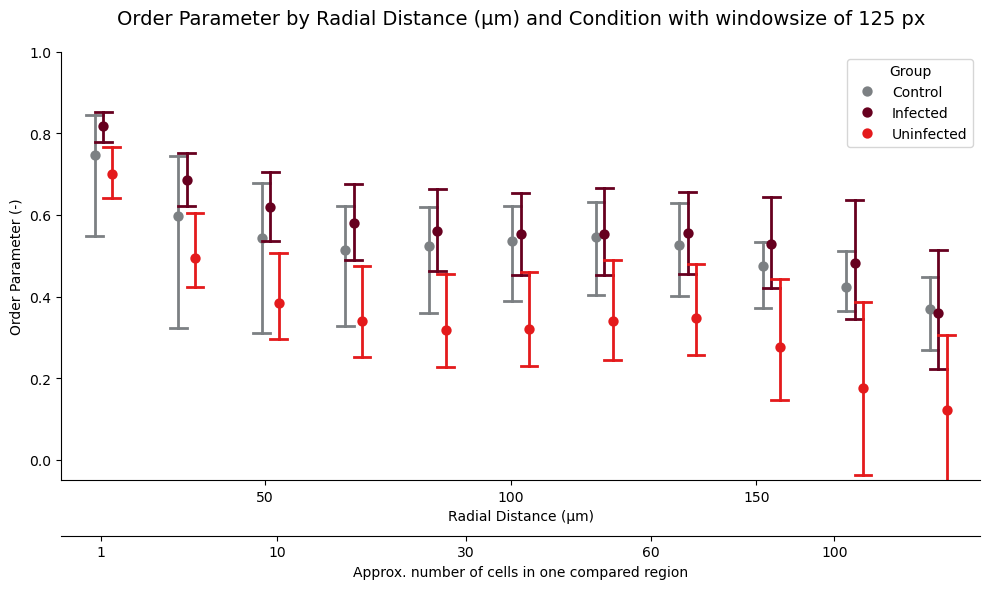

In [19]:
fig = AT.plot_by_windowsize(grouped_df, windowsize=winsize,
                         unit='Radial Distance (µm)', group_col='Infection Status', value_col='Order parameter',  
                         custom_palette=base_colors, group_order = None, doge_condtions=0.2, y_axis_lim=(-0.05,1.0),
                         start_at=0, show_raw_data = False,
                         secondary_label_col='Cells_per_neighbourhood', second_label_pos=40, av_cell_size_um2=av_cell_size_um2)

In [20]:
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig('/media/felix/Felixdrive/Analysis2025/Chip_all/2025_03_18_Chip014_016_019/2025_03_18_Chip014_016_019_Order_parameters_nocrop.svg', format='svg')

In [6]:
kruskal_results, conover_df = AT.perform_kruskal_conover(grouped_df[grouped_df['Window size'] == winsize], 
                                                         value_col='Order parameter', 
                                                         group_col='Infection Status', 
                                                         neighbourhood_col='Radial Distance (µm)')
conover_df

,Radial Distance (µm),Comparison,p-value,Significance
0,17,Control - Infected,0.783376,ns
1,17,Control - Uninfected,0.783376,ns
2,17,Infected - Uninfected,0.108088,ns
3,34,Control - Infected,0.655186,ns
4,34,Control - Uninfected,0.655186,ns
5,34,Infected - Uninfected,0.092984,ns
6,51,Control - Infected,0.623722,ns
7,51,Control - Uninfected,0.312506,ns
8,51,Infected - Uninfected,0.055073,ns
9,68,Control - Infected,0.458060,ns


## Calculate Vectors for Image

This section calculates local order vectors for input images and saves the results.

In [3]:
input_folder = '/media/felix/Felixdrive/HUVEC_indirect_transwell/FIgure/Input/'
output_folder = '/media/felix/Felixdrive/HUVEC_indirect_transwell/FIgure/Output/'
images = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if file.endswith('.tif')]
winsize = 125
overlap = 0.5

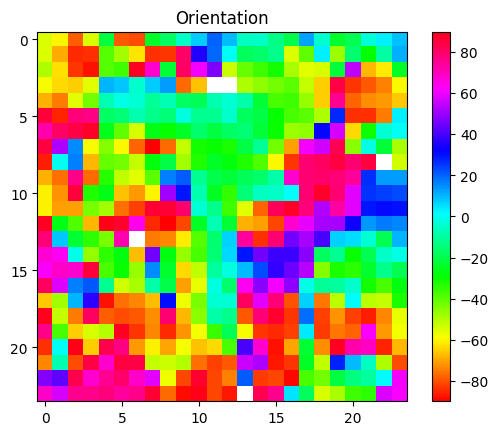

<Figure size 640x480 with 0 Axes>

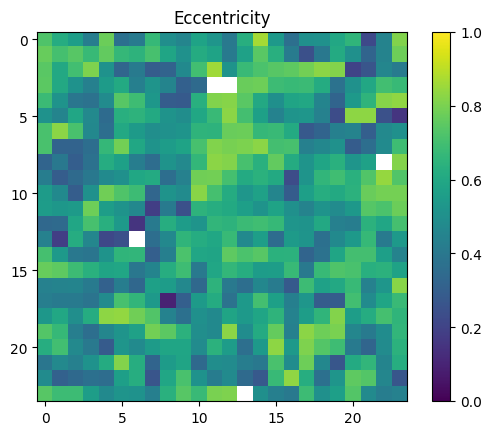

<Figure size 640x480 with 0 Axes>

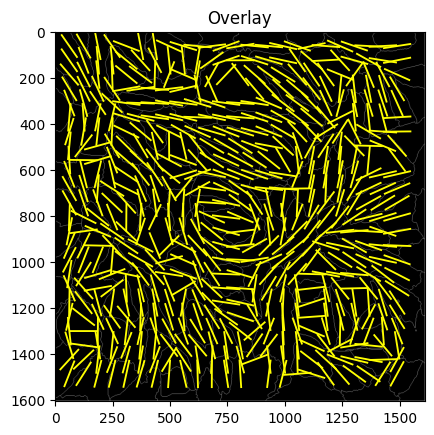

<Figure size 640x480 with 0 Axes>

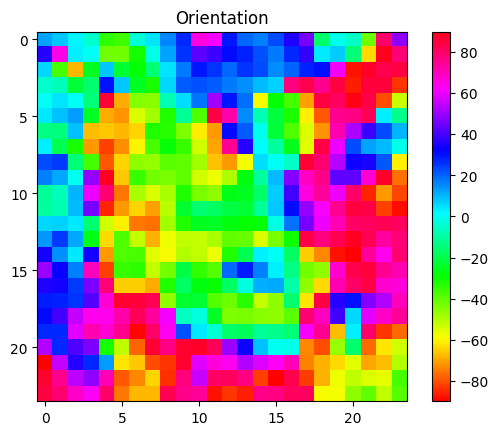

<Figure size 640x480 with 0 Axes>

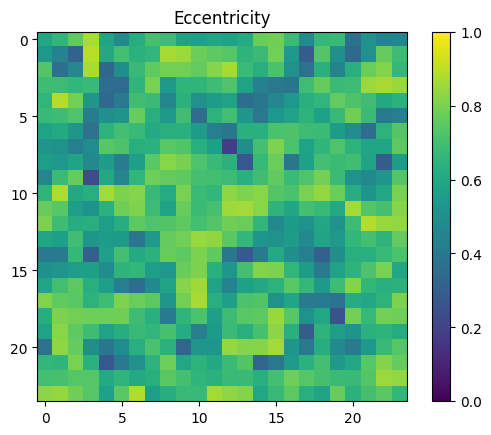

<Figure size 640x480 with 0 Axes>

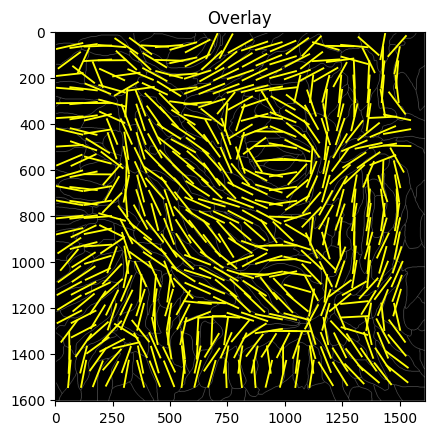

<Figure size 640x480 with 0 Axes>

In [4]:
x_list = []
y_list = []
u_list = []
v_list = []
im_theta_list = []
im_eccentricity_list = []
for i, file in enumerate(images):
    im = io.imread(file)
    x, y, u, v, im_theta, im_eccentricity = AFT.image_local_order(i, im, winsize, overlap, save_path=output_folder, 
                                                             plot_overlay=True, plot_angles=True, plot_eccentricity=True,
                                                             save_figures=True)
    x_list.append(x)
    y_list.append(y)
    u_list.append(u)
    v_list.append(v)
    im_theta_list.append(im_theta)
    im_eccentricity_list.append(im_eccentricity)


#            plt.quiver(x,y,u,v, color='yellow', pivot='mid', scale_units='xy', scale=overlap/2, headaxislength=0, headlength=0, width=0.005)
